# Create_df_from_filter_quad_scan

In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

def interpolate_gradient(current, magnet_type):
	A_Q74L = [5.000978,
			  10.000304,
			  50.002003,
			  100.001404,
			  150.001373,
			  200.00238,
			  250.005432,
			  299.993652,
			  350.001648,
			  399.995728,
			  449.994446,
			  499.997375,
			  549.999878,
			  599.994873,
			  650.004211,
			  666.999146,
			  699.991455,
			  749.998169,
			  799.996643]

	T_Q74L = [0.2619,
			  0.492968,
			  2.358847,
			  4.710821,
			  7.068205,
			  9.426532,
			  11.780794,
			  14.131984,
			  16.4773,
			  18.814776,
			  21.133094,
			  23.416058,
			  25.617934,
			  27.638804,
			  29.43015,
			  29.981004,
			  30.987122,
			  32.347211,
			  33.545971]

	A_Q120C = [0.00,
			   50.00,
			   100.00,
			   150.00,
			   200.00,
			   250.00,
			   300.00,
			   350.00,
			   400.00,
			   450.00,
			   500.00,
			   550.00,
			   600.00,
			   650.00]

	T_Q120C = [0.00,
			   2.05,
			   4.12,
			   6.19,
			   8.26,
			   10.33,
			   12.39,
			   14.43,
			   16.44,
			   18.36,
			   20.14,
			   21.74,
			   23.01,
			   24.07]

	A_QFL = [0,
			 94.15,
			 145.76,
			 197.97,
			 250.74,
			 300.18,
			 350.7,
			 402,
			 451.15,
			 502.09,
			 551.47]

	T_QFL = [0,
			 4.86,
			 7.48,
			 10.158,
			 12.875,
			 15.377,
			 17.81,
			 20.045,
			 21.844,
			 23.217,
			 24.445]

	if magnet_type == "Q74L":
		measured_currents = A_Q74L
		measured_int_gradient = T_Q74L
	if magnet_type == "Q120C":
		measured_currents = A_Q120C
		measured_int_gradient = T_Q120C
	if magnet_type == "QFL":
		measured_currents = A_QFL
		measured_int_gradient = T_QFL

	# Make the curve symmetric
	if (current < 0):
		interpolated_int_gradient = -np.interp(-current, measured_currents, measured_int_gradient)
	else:
		interpolated_int_gradient = np.interp(current, measured_currents, measured_int_gradient)

	return interpolated_int_gradient

# Filter measurement

In [3]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/"
# end_path = "quad_scan_east_dump_with_filters_data/"
end_path = "quad_scan_east_slow_ions_high_energy_data/"
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [4]:
dirnames

['quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s',
 'quad_scan_east_slow_ions_high_energy_2022_09_26_16h00m25s',
 'quad_scan_east_slow_ions_high_energy_2022_09_26_16h50m24s']

In [5]:
# Take the last image
subset_dirnames = [dirnames[0]]
subset_dirnames

['quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s']

In [6]:
btv_name = "F61D.BTV010/Image"
df = pd.DataFrame(data = {"time": [], "Image": [], "Image_processed": [], "Acqu": [], "Intensity": [], "Filter": [], "sigmaSet1": [],
                          "i_qfn01": [], "i_qdn02": [], "i_qfn03": [],
                          "k_qfn01": [], "k_qdn02": [], "k_qfn03": [],
                          #"i_func_qfn01": [],
#                           "i_func_qdn02": [],
#                           "i_func_qfn03": [],
#                           "i_oasis_qfn01": [], "i_oasis_qdn02": [], "i_oasis_qfn03": [],
                         })
for dirname in subset_dirnames:
    print (dirname)
    infile = open(start_path+end_path+"/"+dirname+"/"+dirname+".p", 'rb')
    loaded_pickle = pickle.load(infile)
    
    pixel_y = len(loaded_pickle[2][btv_name][0]["imagePositionSet2"][0])

    for j in range(len(loaded_pickle[0])):
        for i in range(6):
            try:
                image = loaded_pickle[2][btv_name][j]["imageSet"][i]
                reshaped_image = image.reshape(pixel_y,-1)
                reshaped_image = reshaped_image/4095 #Normalize
                med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))

                try:
                    df2 = pd.DataFrame(data = {"time": loaded_pickle[0][j],
                                                "Image": [reshaped_image], "Image_processed": [med_filter_image], "Acqu": [i],
                                               "Intensity": [loaded_pickle[5][j]],
#                                                "Filter": [loaded_pickle[2][btv_name][j]["filterSelect"][1]],
                                               "sigmaSet1": loaded_pickle[2][btv_name][j]["sigmaSet1"][i],
                                               "i_qfn01": loaded_pickle[3]["F61.QFN01/MEAS.PULSE#VALUE"][j],
                                               "i_qdn02": loaded_pickle[3]["F61.QDN02/MEAS.PULSE#VALUE"][j],
                                               "i_qfn03": loaded_pickle[3]["F61.QFN03/MEAS.PULSE#VALUE"][j],
                                               "k_qfn01": loaded_pickle[4]["logical.F61.QFN01/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qdn02": loaded_pickle[4]["logical.F61.QDN02/K_FUNC_LIST#value"][j][0][1][0],
                                               "k_qfn03": loaded_pickle[4]["logical.F61.QFN03/K_FUNC_LIST#value"][j][0][1][0],
    #                                            "i_func_qfn01": loaded_pickle[6]["logical.F61.QFN01/I_FUNC_LIST#value"][j][0],
#                                                "i_func_qdn02": [loaded_pickle[6]["logical.F61.QDN02/I_FUNC_LIST#value"][j][0]],
#                                                "i_func_qfn03": [loaded_pickle[6]["logical.F61.QFN03/I_FUNC_LIST#value"][j][0]],
#                                                "i_oasis_qfn01": [loaded_pickle[7]["F61.QFN01/LOG.OASIS.I_MEAS#DATA"][j]],
#                                                "i_oasis_qdn02": [loaded_pickle[7]["F61.QDN02/LOG.OASIS.I_MEAS#DATA"][j]],
#                                                "i_oasis_qfn03": [loaded_pickle[7]["F61.QFN03/LOG.OASIS.I_MEAS#DATA"][j]],
                                              })
                except:
                    print("here")
                df = pd.concat([df,df2])
            except:
                print("error")
                pass
df.reset_index(drop=True, inplace=True)

# Add saturation colum
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image == 1).sum())
df["Saturation"] = saturation_list
saturation_list = []
for i in range(len(df)):
    saturation_list.append((df.iloc[i].Image_processed == 255).sum())
df["Saturation_processed"] = saturation_list
    
df.head(5)

quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s


/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/skimage/util/dtype.py:140: UserWarning: Possible precision loss when converting from float64 to uint8
  warn("Possible precision loss when converting from {} to {}"


error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


time  \
0 2022-09-26 15:31:29.275195   
1 2022-09-26 15:31:29.275195   
2 2022-09-26 15:31:29.275195   
3 2022-09-26 15:31:29.275195   
4 2022-09-26 15:31:37.106137   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity  Filter  \
0  [[1, 1, 1, 1, 3, 5, 5, 3, 3, 3, 3, 5, 4, 2, 2,...   0.0   1.078415     NaN   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1.0   1.078415     NaN   
2  [[5, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,...   2.0   1.078415     NaN   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   3.0   1.078415     NaN   
4  [[7, 0, 0, 0, 5, 3, 3, 3, 2, 2, 2, 3, 3, 1, 1,...   0.0   1.204157     NaN   

       sigmaSet1     i_qfn01     i_qdn02     i_qfn03  k_qfn01  k_qdn02  \
0  4.446591e-323  583.090576  266.497192  250.066406  0.45000  -0.1149   
1   3.651006e+00  583.090576  266.497192  250.066406  0.45000  -0.1149   
2  4.446591e-323  583.090576  266.497192  250.066406  0.45000  -0.1149   
3   6.457528e-01  583.090576  266.497192  250.066406  0.45000  -0.1149   
4  4.446591e-323  575.889648  266.499207  250.065491  0.45124  -0.1149   

   k_qfn03  Saturation  Saturation_processed  
0    0.134           0                     0  
1    0.134           0                     0  
2    0.134           0                     0  
3    0.134           0                     0  
4    0.134           0                     0

In [7]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        Image_processed = df.iloc[i].Image_processed.copy()

        Hy = Image_processed.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = Image_processed.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(0,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, 0, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, 0, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH_proc"] = gaussian_maxH_list
# df["gaussian_maxV_proc"] = gaussian_maxV_list

# df["poptH0_proc"] = poptH0_list
# df["poptH1_proc"] = poptH1_list
# df["poptH2_proc"] = poptH2_list
# df["poptH3_proc"] = poptH3_list
df["muH_proc"] = muH_list
df["muErrH_proc"] = muH_err_list
df["sigH_proc"] = sigH_list
df["sigErrH_proc"] = sigH_err_list


# df["poptV0_proc"] = poptV0_list
# df["poptV1_proc"] = poptV1_list
# df["poptV2_proc"] = poptV2_list
# df["poptV3_proc"] = poptV3_list
df["muV_proc"] = muV_list
df["muErrV_proc"] = muV_err_list
df["sigV_proc"] = sigV_list
df["sigErrV_proc"] = sigV_err_list

# df["integralH_proc"] = integralH_list
# df["integralV_proc"] = integralV_list
print (f"{len(df[np.isnan(df.muH_proc)].muH_proc)}/{len(df)} failed fit")

print (f"muH: {int(df.muH_proc.median())}")
print (f"muV: {int(df.muV_proc.median())}")
print (f"sigH: {int(df.sigH_proc.median())}")
print (f"sigV: {int(df.sigV_proc.median())}")

79/108 failed fit
muH: 167
muV: -14
sigH: 7
sigV: 27


# Add a column with automatically adjusted mask from first fit

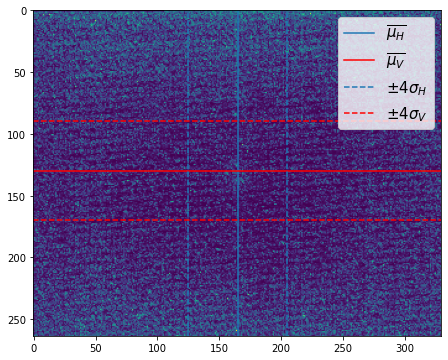

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
i = 99
ax.imshow(df.loc[i].Image)

#Override the mask
muH_median = df.iloc[i].muH_proc
muV_median = df.iloc[i].muV_proc
sigH_median = df.iloc[i].sigH_proc
sigV_median = df.iloc[i].sigV_proc

muH_median = 165
muV_median = 130
sigH_median = 10
sigV_median = 10

ax.axvline(muH_median, label = "$\overline{\mu_{H}}$")
ax.axhline(muV_median, color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(muH_median + 4*sigH_median, linestyle="--", label="$\pm4{\sigma_{H}}$")
ax.axvline(muH_median - 4*sigH_median, linestyle="--")

ax.axhline(muV_median + 4*sigV_median, linestyle="--", color="r", label="$\pm4{\sigma_{V}}$")
ax.axhline(muV_median - 4*sigV_median, linestyle="--", color="r")

ax.legend(fontsize=15)

In [9]:
# Add masked colum
image_processed_masked_list = []
for i in range(len(df)):
    
    image_processed_masked = df.iloc[i].Image_processed.copy()
    
    h, w = image_processed_masked.shape[:2]
    mask = create_elliptical_mask(h, w, center=(df.iloc[i].muH_proc,df.iloc[i].muV_proc), radius = 1, a=4*df.iloc[i].sigH_proc, b=4*df.iloc[i].sigV_proc)
    mask = create_elliptical_mask(h, w, center=(muH_median, muV_median), radius = 1, a=4*sigH_median, b=4*sigV_median)
    masked_img = image_processed_masked.copy()
    masked_img[~mask] = 0

    image_processed_masked_list.append(masked_img)
    
df["Image_processed_masked"] = image_processed_masked_list
df.head(1)

time  \
0 2022-09-26 15:31:29.275195   

                                               Image  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     Image_processed  Acqu  Intensity  Filter  \
0  [[1, 1, 1, 1, 3, 5, 5, 3, 3, 3, 3, 5, 4, 2, 2,...   0.0   1.078415     NaN   

       sigmaSet1     i_qfn01     i_qdn02     i_qfn03  ...  \
0  4.446591e-323  583.090576  266.497192  250.066406  ...   

   Saturation_processed  muH_proc  muErrH_proc  sigH_proc  sigErrH_proc  \
0                     0       NaN          NaN        NaN           NaN   

   muV_proc  muErrV_proc  sigV_proc  sigErrV_proc  \
0       NaN          NaN        NaN           NaN   

                              Image_processed_masked  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 24 columns]

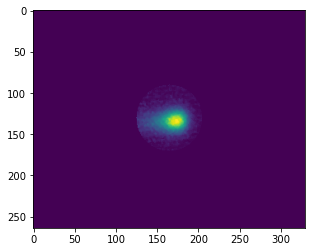

In [10]:
fig, ax = plt.subplots()
ax.imshow(df.iloc[1].Image_processed_masked)

# Add fit for Image_processed_masked

In [11]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(0, len(Hy)-1, len(Hy))

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(0, len(Vy)-1, len(Vy))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
        
        try:
            #Integration
            x = np.linspace(-300,300,300)
            gaussH = lambda x: gaussian_function(x, poptH[0], poptH[1], poptH[2], poptH[3])
            integralH = (integrate.quad(gaussH, -300, 300))

            gaussV = lambda x: gaussian_function(x, poptV[0], poptV[1], poptV[2], poptV[3])
            integralV = (integrate.quad(gaussV, -300, 300))

            integralH_list.append(integralH[0])
            integralV_list.append(integralV[0])
        except:
            print("failed integration")
            pass
            
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

df["gaussian_maxH"] = gaussian_maxH_list
df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0"] = poptH0_list
df["poptH1"] = poptH1_list
df["poptH2"] = poptH2_list
df["poptH3"] = poptH3_list
df["muH"] = muH_list
df["muErrH"] = muH_err_list
df["sigH"] = sigH_list
df["sigErrH"] = sigH_err_list


df["poptV0"] = poptV0_list
df["poptV1"] = poptV1_list
df["poptV2"] = poptV2_list
df["poptV3"] = poptV3_list
df["muV"] = muV_list
df["muErrV"] = muV_err_list
df["sigV"] = sigV_list
df["sigErrV"] = sigV_err_list

df["integralH"] = integralH_list
df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.muH)].muH_proc)}/{len(df)} failed fit")

0/108 failed fit


# Fit with pixel calibration

In [12]:
# Add fitting colums
gaussian_maxH_list = []
gaussian_maxV_list = []

poptH0_list = []
poptH1_list = []
poptH2_list = []
poptH3_list = []

poptV0_list = []
poptV1_list = []
poptV2_list = []
poptV3_list = []

muH_list = []
muH_err_list = []
muV_list = []
muV_err_list = []

sigH_list = []
sigH_err_list = []
sigV_list = []
sigV_err_list = []

integralH_list = []
integralV_list = []


for i in range(len(df)):

    try:
        image_processed_masked = df.iloc[i].Image_processed_masked.copy()

        Hy = image_processed_masked.sum(axis=0)
        Hx = np.linspace(min(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet1"][0]), max(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet1"][0]), len(image_processed_masked.sum(axis=0))) # Pixel calibration

        Vy = image_processed_masked.sum(axis=1)
        Vx = np.linspace(min(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet2"][0]), max(loaded_pickle[1]["F61D.BTV010/Acquisition"][0]["projPositionSet2"][0]), len(image_processed_masked.sum(axis=1)))

        # H
        poptH, pcovH = do_gaussian_fit(Hx, Hy)

        gaussian_maxH = gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]).max()

        # V
        poptV, pcovV = do_gaussian_fit(Vx, Vy)

        gaussian_maxV = gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]).max()

        gaussian_maxH_list.append(gaussian_maxH)
        gaussian_maxV_list.append(gaussian_maxV)
        
        poptH0_list.append(poptH[0])
        poptH1_list.append(poptH[1])
        poptH2_list.append(poptH[2])
        poptH3_list.append(poptH[3])
        
        poptV0_list.append(poptV[0])
        poptV1_list.append(poptV[1])
        poptV2_list.append(poptV[2])
        poptV3_list.append(poptV[3])

        
        muH_list.append(poptH[2])
        muH_err_list.append(pcovH[2, 2] ** 0.5)
        muV_list.append(poptV[2])
        muV_err_list.append(pcovV[2, 2] ** 0.5)
        
        sigH_list.append(poptH[3])
        sigH_err_list.append(pcovH[3, 3] ** 0.5)
        sigV_list.append(poptV[3])
        sigV_err_list.append(pcovV[3, 3] ** 0.5)
                   
        
    except:
        gaussian_maxH_list.append(np.nan)
        gaussian_maxV_list.append(np.nan)

        poptH0_list.append(np.nan)
        poptH1_list.append(np.nan)
        poptH2_list.append(np.nan)
        poptH3_list.append(np.nan)
        
        poptV0_list.append(np.nan)
        poptV1_list.append(np.nan)
        poptV2_list.append(np.nan)
        poptV3_list.append(np.nan)
        
        muH_list.append(np.nan)
        muH_err_list.append(np.nan)
        muV_list.append(np.nan)
        muV_err_list.append(np.nan)
        
        sigH_list.append(np.nan)
        sigH_err_list.append(np.nan)
        sigV_list.append(np.nan)
        sigV_err_list.append(np.nan)
        
        integralH_list.append(np.nan)
        integralV_list.append(np.nan)
#         print("Failed fit")

# df["gaussian_maxH"] = gaussian_maxH_list
# df["gaussian_maxV"] = gaussian_maxV_list

df["poptH0_cal"] = poptH0_list
df["poptH1_cal"] = poptH1_list
df["poptH2_cal"] = poptH2_list
df["poptH3_cal"] = poptH3_list
# df["muH"] = muH_list
# df["muErrH"] = muH_err_list
# df["sigH"] = sigH_list
df["sigErrH_cal"] = sigH_err_list


df["poptV0_cal"] = poptV0_list
df["poptV1_cal"] = poptV1_list
df["poptV2_cal"] = poptV2_list
df["poptV3_cal"] = poptV3_list
# df["muV"] = muV_list
# df["muErrV"] = muV_err_list
# df["sigV"] = sigV_list
df["sigErrV_cal"] = sigV_err_list

# df["integralH"] = integralH_list
# df["integralV"] = integralV_list

print (f"{len(df[np.isnan(df.poptH3_cal)].poptH3_cal)}/{len(df)} failed fit")

0/108 failed fit


# Look at data

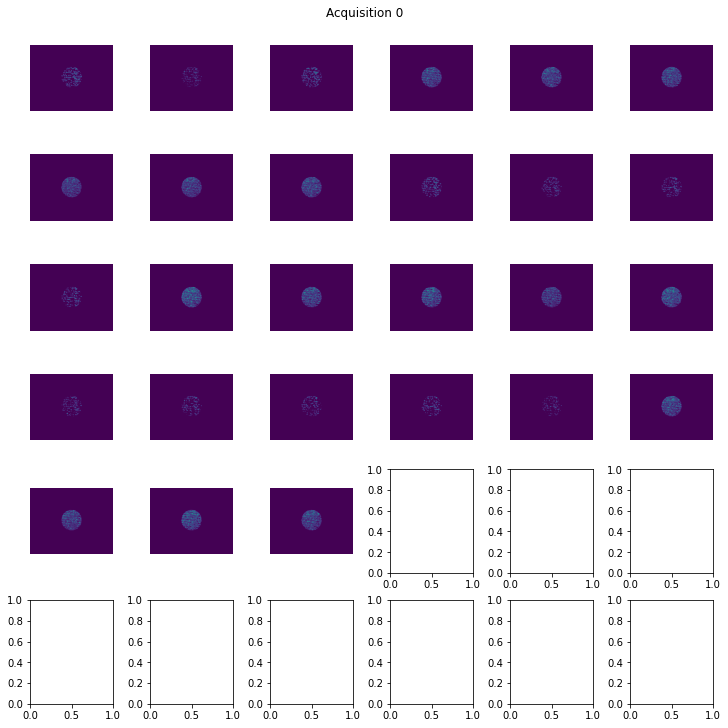

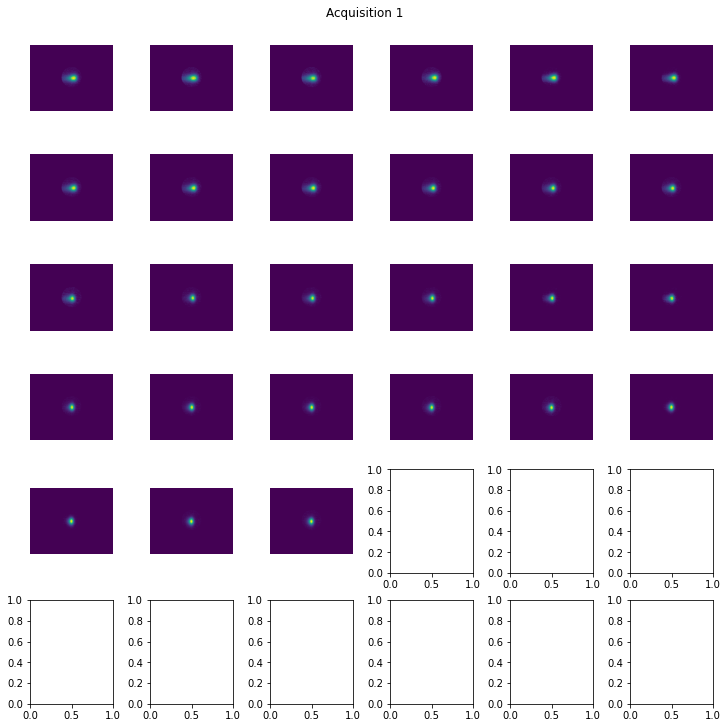

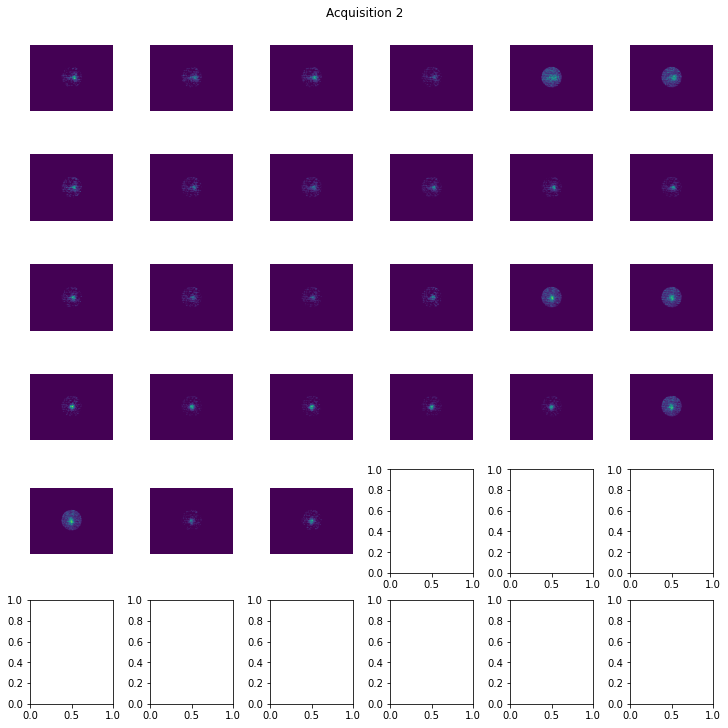

In [13]:
for acq in range(3):
    df_acq = df[df.Acqu==acq].copy()

    fig, ax = plt.subplots(6, 6, figsize=(10,10),constrained_layout=True)
    fig.suptitle(f"Acquisition {acq}")
    for i in range(len(df_acq)):
        ax[i//6,i%6].imshow(df_acq.iloc[i].Image_processed_masked)
        ax[i//6,i%6].set_axis_off()

In [14]:
import pickle

madxdf = pickle.load( open( "/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/F61D_madx_quad_scan1.pickle", "rb" ) )

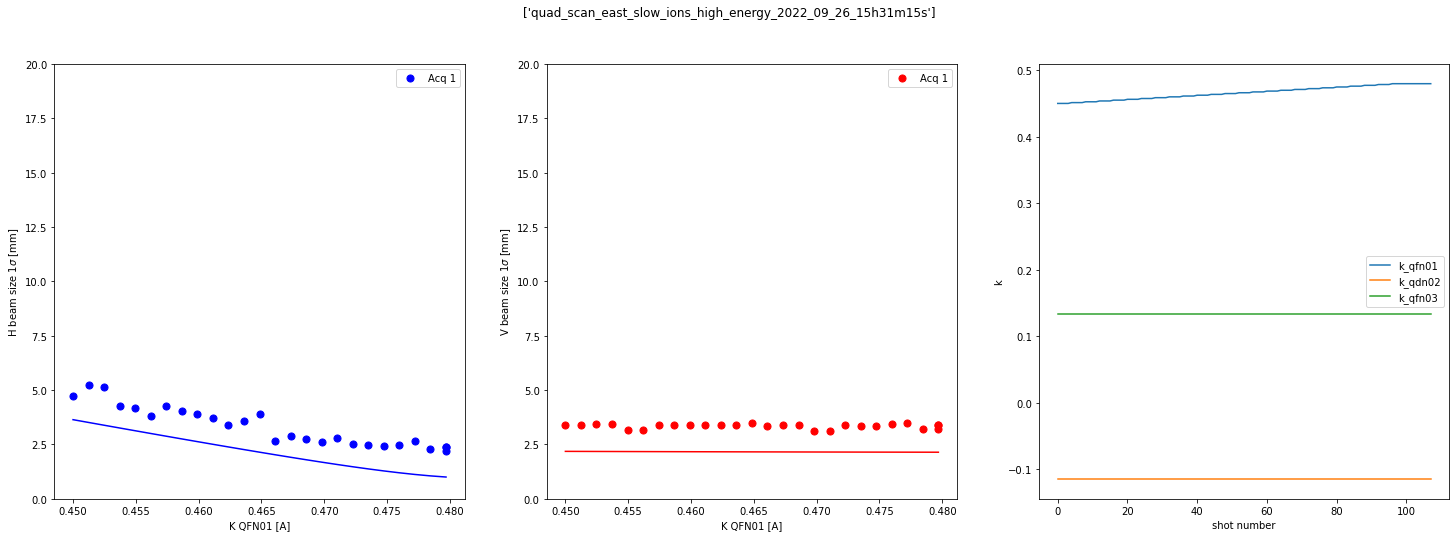

In [15]:
fig, ax = plt.subplots(1,3, figsize=(25,8))

df_acq = df[df.Acqu==1].copy()
ax[0].scatter(df_acq.k_qfn01, df_acq.poptH3_cal, color="blue", label="Acq 1",s=50)
ax[1].scatter(df_acq.k_qfn01, df_acq.poptV3_cal, color="red", label="Acq 1",s=50)

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
# ax[1].set_ylim(1.5, 5)

df_acq.reset_index(drop=True, inplace=True)
ax[2].plot(df.k_qfn01, label="k_qfn01")
ax[2].plot(df.k_qdn02, label="k_qdn02")
ax[2].plot(df.k_qfn03, label="k_qfn03")
ax[2].set_xlabel("shot number")
ax[2].set_ylabel("k")
ax[2].legend()
fig.suptitle(f"{subset_dirnames}")

ax[0].set_ylim(0,20)
ax[1].set_ylim(0,20)

# # MAD-X
ax[0].plot(madxdf.strength,madxdf.sigmaH*1000, color = "blue", label ="H MAD-X")
ax[1].plot(madxdf.strength,madxdf.sigmaV*1000, color = "red", label = "V MAD-X")
plt.savefig("fig/quadrupole_scan"+str(subset_dirnames[0])+".png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

# Median of acquisitions at a certain optics

Text(0.5, 0.98, "['quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s']")

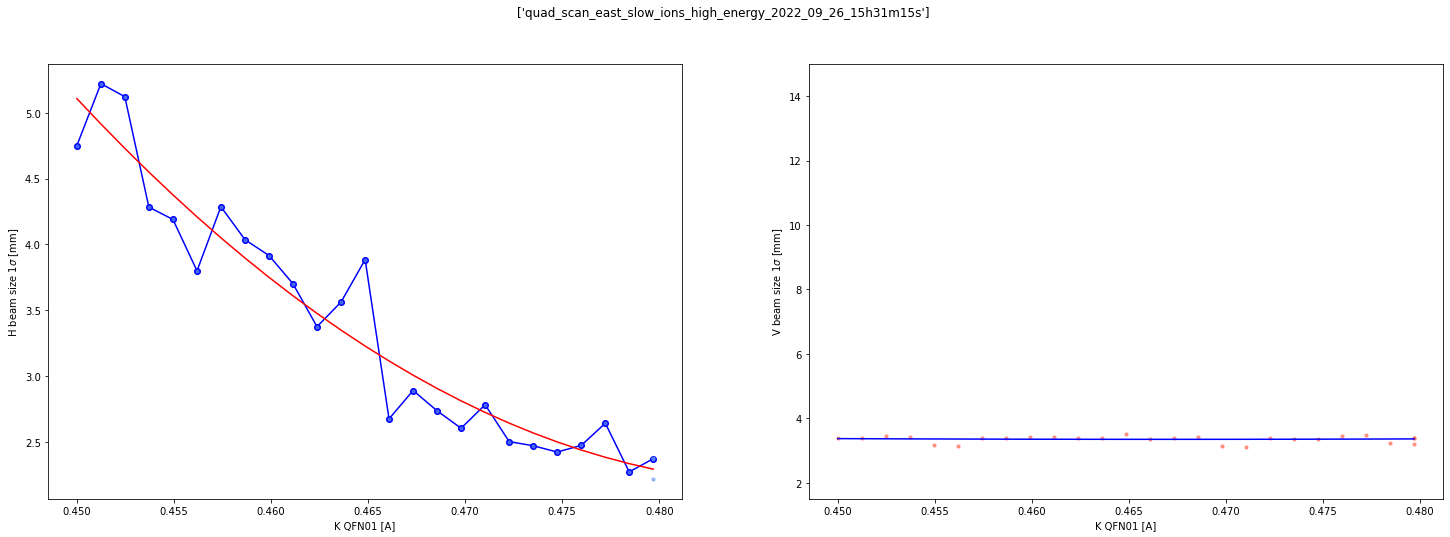

In [16]:
fig, ax = plt.subplots(1,2, figsize=(25,8))

x_med = []
y_medH = []
y_medV = []

for k_qfn01 in (df.k_qfn01.unique()):

    mini_df = df.loc[(df.k_qfn01 == k_qfn01) & (df.Acqu == 1) & (df.Saturation < 100)].copy()
    
    ax[0].scatter(mini_df.k_qfn01, mini_df.poptH3_cal, color="cornflowerblue", s=10, alpha=0.6, label="Acq 3", zorder=9)
    ax[1].scatter(mini_df.k_qfn01, mini_df.poptV3_cal, color="tomato", s=10, alpha=0.6, label="Acq 3", zorder=9)
    
    x_med.append(mini_df.k_qfn01.median())
    y_medH.append(mini_df.poptH3_cal.median())
    y_medV.append(mini_df.poptV3_cal.median())
    
#Horizontal
ax[0].plot(x_med, y_medH, color="blue", marker="o")
pfitH = np.poly1d(np.polyfit(x_med, y_medH, 2))
ax[0].plot(x_med, pfitH(x_med), color="red", zorder=100)

# Vertical
# ax[1].plot(x_med, y_medV, color="red", marker="o")
pfitV = np.poly1d(np.polyfit(x_med, y_medV, 2))
ax[1].plot(x_med, pfitV(x_med), color="blue", zorder=100)

ax[0].set_xlabel("K QFN01 [A]")
ax[0].set_ylabel("H beam size $1\sigma$ [mm]")

ax[1].set_xlabel("K QFN01 [A]")
ax[1].set_ylabel("V beam size $1\sigma$ [mm]")
ax[1].set_ylim(1.5, 15)

fig.suptitle(f"{subset_dirnames}")

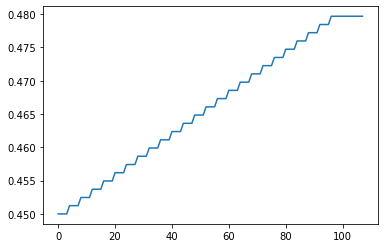

In [17]:
fig, ax = plt.subplots()
ax.plot(df.k_qfn01)

In [18]:
new_df = df.loc[df.Acqu==1].filter(["Acqu","k_qfn01","k_qdn02","k_qfn03"]).copy()

new_df.head(10)

Acqu  k_qfn01  k_qdn02  k_qfn03
1    1.0  0.45000  -0.1149    0.134
5    1.0  0.45124  -0.1149    0.134
9    1.0  0.45247  -0.1149    0.134
13   1.0  0.45371  -0.1149    0.134
17   1.0  0.45495  -0.1149    0.134
21   1.0  0.45619  -0.1149    0.134
25   1.0  0.45742  -0.1149    0.134
29   1.0  0.45866  -0.1149    0.134
33   1.0  0.45990  -0.1149    0.134
37   1.0  0.46113  -0.1149    0.134

# Remove the copies of the optics as we don't need 5 times of the same value

In [19]:
new_df.drop_duplicates(inplace=True)

my_list = []
my_listV = []
for i in range(len(new_df)):
    my_list.append(pfitH(new_df.iloc[i].k_qfn01))
    my_listV.append(pfitV(new_df.iloc[i].k_qfn01))
new_df["sigH"] = my_list
new_df["sigV"] = my_listV

with open('new_df.pickle', 'wb') as handle:
        pickle.dump(new_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

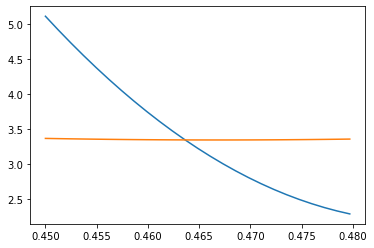

In [20]:
fig, ax = plt.subplots()
ax.plot(new_df.k_qfn01, new_df.sigH)
ax.plot(new_df.k_qfn01, new_df.sigV)

# Write to pickle

In [21]:
with open('../df/small_df/df_'+str(subset_dirnames[0])+'.pickle', 'wb') as handle:
        pickle.dump(new_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../df/large_df/df_'+str(subset_dirnames[0])+'.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
subset_dirnames[0]

'quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s'